# CoCliCo: working with Zarr data

Notebook contains several examples of writing data (mainly JRC datasets) from NetCDFs to Zarr stores.

TODO: 
- make consistent with cf conventions
- bold names due to a dimension index (maybe this should be changed..)

In [13]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [152]:
# imports
import os
import pathlib
import sys
import platform
import xarray as xr
import pandas as pd
import zarr

# make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# OS independent path configurations
if platform.system() == "Windows":
    root = pathlib.Path("P:/")
else:  # linux or other
    root = pathlib.Path("/p/")
# root = pathlib.Path().home().root
coclico_data_dir = pathlib.Path(root, "11205479-coclico", "data")

<IPython.core.display.Javascript object>

## Write Storm Surge (dataset 1) JRC to Zarr

In [88]:
# Extreme Sea Level (JRC) paths for example how to migrate netcdf to zarr
eessl_dir = coclico_data_dir.joinpath("01_storm_surge_jrc")
eessl_historical_path = eessl_dir.joinpath("CoastAlRisk_Europe_EESSL_Historical.nc")
eessl_rcp45_path = eessl_dir.joinpath("CoastAlRisk_Europe_EESSL_RCP45.nc")
eessl_rcp85_path = eessl_dir.joinpath("CoastAlRisk_Europe_EESSL_RCP85.nc")

eessl_historical = xr.open_dataset(eessl_historical_path)
eessl_45rcp = xr.open_dataset(eessl_rcp45_path)
eessl_85rcp = xr.open_dataset(eessl_rcp85_path)

<IPython.core.display.Javascript object>

In [89]:
eessl_historical

<xarray.Dataset>
Dimensions:    (row: 2242, col: 8)
Dimensions without coordinates: row, col
Data variables:
    longitude  (row) float64 ...
    latitude   (row) float64 ...
    ssl        (row, col) float64 ...
    RP         (col) float32 ...
Attributes:
    title:            European extreme storm surge level
    Institution:      Joint European Research Center, Institute of Environmen...
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Project Acronym:  CoastAlRisk
    reference:        Vousdoukas MI, Voukouvalas E, Annunziato A, Giardino A,...
    email:            michail.vousdoukas@ec.europa.eu
    version:          1.0
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    disclaimer:       Unless the following would not be permitted or valid un...

<IPython.core.display.Javascript object>

In [95]:
# set some data variables to coordinates to avoid duplication of dimensions in later stage
eessl_historical = eessl_historical.set_coords(["longitude", "latitude", "RP"])
eessl_45rcp = eessl_45rcp.set_coords(["longitude", "latitude", "RP"])
eessl_85rcp = eessl_85rcp.set_coords(["longitude", "latitude", "RP"])

<IPython.core.display.Javascript object>

In [134]:
# concat datasets along new dimension with index values and name derived from pandas index object
eessl = xr.concat(
    [eessl_historical, eessl_45rcp, eessl_85rcp],
    pd.Index(["historical", "rcp45", "rcp85"], name="scenario"),
)

<IPython.core.display.Javascript object>

In [97]:
# rename dimension names and re-order shape of data variables
eessl = eessl.rename_dims({"row": "stations", "col": "rp"})
eessl = eessl.transpose("scenario", "stations", "rp")

<IPython.core.display.Javascript object>

In [98]:
# scenario is in bold because the coordinate is a dimension index (maybe this should be changed..)
eessl

<xarray.Dataset>
Dimensions:    (stations: 2242, scenario: 3, rp: 8)
Coordinates:
    longitude  (stations) float64 -0.1 -0.1 -0.1 -0.1 -0.3 ... 9.9 9.9 9.9 9.9
    latitude   (stations) float64 36.1 39.3 49.7 54.3 ... 57.7 58.7 64.5 64.7
    RP         (rp) float32 5.0 10.0 20.0 50.0 100.0 200.0 500.0 1e+03
  * scenario   (scenario) object 'historical' 'rcp45' 'rcp85'
Dimensions without coordinates: stations, rp
Data variables:
    ssl        (scenario, stations, rp) float64 1.024 1.051 ... 2.712 2.805
Attributes:
    title:            European extreme storm surge level
    Institution:      Joint European Research Center, Institute of Environmen...
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Project Acronym:  CoastAlRisk
    reference:        Vousdoukas MI, Voukouvalas E, Annunziato A, Giardino A,...
    email:            michail.vousdoukas@ec.europa.eu
    version:          1.0
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    disclaimer:       Unless the following would not be permitted or valid un...

<IPython.core.display.Javascript object>

In [30]:
# export to zarr in write mode (to overwrite iff exists)
eessl.to_zarr(eessl_dir.joinpath("CoastAlRisk_Europe_EESSL.zarr"), mode="w")

<IPython.core.display.Javascript object>

## Write Wave Energy Flux (dataset 2) JRC to Zarrr

In [99]:
# Wave Energy JRC (WEF) paths

wef_dir = coclico_data_dir.joinpath("02_wave_energy_jrc")
wef_path = wef_dir.joinpath("CoastAlRisk_Global_WEF_RCP85.nc")

<IPython.core.display.Javascript object>

In [101]:
wef = xr.open_dataset(wef_path)
wef = wef.rename_vars({"rp": "RP"})

<IPython.core.display.Javascript object>

In [102]:
wef

<xarray.Dataset>
Dimensions:    (npoints: 4828, nrp: 8, nsdec: 11)
Dimensions without coordinates: npoints, nrp, nsdec
Data variables:
    longitude  (npoints) float64 ...
    latitude   (npoints) float64 ...
    wef        (npoints, nrp, nsdec) float64 ...
    RP         (nrp) float32 ...
    decades    (nsdec) float32 ...
Attributes:
    title:            Global Wave Energy Flux
    Institution:      Joint European Research Center, Directorate for Space, ...
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Project Acronym:  CoastAlRisk
    reference:        Mentaschi L., Vousdoukas M., Voukouvalas E., Dosio A., ...
    email:            lorenzo.mentaschi@ec.europa.eu
    version:          1.0
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    disclaimer:       Unless the following would not be permitted or valid un...

<IPython.core.display.Javascript object>

In [103]:
# format data; renames now according to earlier processed datasets (storm surge).

wef = wef.rename_dims({"npoints": "stations", "nsdec": "time", "nrp": "rp"}).set_coords(
    ["longitude", "latitude", "RP", "decades"]
)

<IPython.core.display.Javascript object>

In [104]:
wef

<xarray.Dataset>
Dimensions:    (stations: 4828, rp: 8, time: 11)
Coordinates:
    longitude  (stations) float64 -180.0 -180.0 -180.0 ... 181.3 181.5 181.6
    latitude   (stations) float64 71.87 69.81 71.87 ... -18.52 -17.54 -16.57
    RP         (rp) float32 5.0 10.0 20.0 50.0 100.0 200.0 500.0 1e+03
    decades    (time) float32 1.995e+03 2.01e+03 2.02e+03 ... 2.09e+03 2.1e+03
Dimensions without coordinates: stations, rp, time
Data variables:
    wef        (stations, rp, time) float64 ...
Attributes:
    title:            Global Wave Energy Flux
    Institution:      Joint European Research Center, Directorate for Space, ...
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Project Acronym:  CoastAlRisk
    reference:        Mentaschi L., Vousdoukas M., Voukouvalas E., Dosio A., ...
    email:            lorenzo.mentaschi@ec.europa.eu
    version:          1.0
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    disclaimer:       Unless the following would not be permitted or valid un...

<IPython.core.display.Javascript object>

In [107]:
# Write to zarr store in write mode to overwrite iff exists
wef.to_zarr(wef_path.with_suffix(".zarr"), mode="w")

<IPython.core.display.Javascript object>

## Write Extreme Sea Level (dataset 3) JRC to Zarr

In [109]:
# Extreme Sea Level (JRC) paths for example how to migrate netcdf to zarr
esl_dir = coclico_data_dir.joinpath("03_sea_level_jrc")
esl_rcp45_path = esl_dir.joinpath("CoastAlRisk_Europe_ESL_RCP45_new.nc")
esl_rcp85_path = esl_dir.joinpath("CoastAlRisk_Europe_ESL_RCP85_new.nc")

<IPython.core.display.Javascript object>

In [130]:
# open NetCDF with xarray and only keep mean ensemble
esl_rcp45 = xr.open_dataset(esl_rcp45_path)
esl_rcp85 = xr.open_dataset(esl_rcp85_path)
# esl_rcp45 = esl_rcp45.isel(nens=1) # select the mean
esl_rcp45 = esl_rcp45.rename_vars({"rp": "RP", "ensmbl": "ensemble"})
esl_rcp85 = esl_rcp85.rename_vars({"rp": "RP", "ensmbl": "ensemble"})

<IPython.core.display.Javascript object>

In [131]:
esl_rcp45

<xarray.Dataset>
Dimensions:    (npoints: 11014, nrp: 8, nens: 3, nsdec: 11)
Dimensions without coordinates: npoints, nrp, nens, nsdec
Data variables:
    longitude  (npoints) float64 ...
    latitude   (npoints) float64 ...
    esl        (npoints, nrp, nens, nsdec) float64 ...
    eewl       (npoints, nrp, nens, nsdec) float64 ...
    RP         (nrp) float32 ...
    ensemble   (nens) float32 ...
    decades    (nsdec) float32 ...
Attributes:
    title:            Extreme Sea Levels
    Institution:      Joint European Research Center, Directorate for Space, ...
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Project Acronym:  CoastAlRisk
    reference:         Vousdoukas MI., Mentaschi L., Voukouvalas E., Verlaan ...
    email:            michail.vousdoukas@ec.europa.eu
    version:          1.2
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    disclaimer:       Unless the following would not be permitted or valid un...

<IPython.core.display.Javascript object>

In [132]:
# set some data variables to coordinates to avoid duplication of dimensions in later stage
esl_rcp45 = esl_rcp45.set_coords(["longitude", "latitude", "RP", "ensemble", "decades"])
esl_rcp85 = esl_rcp85.set_coords(["longitude", "latitude", "RP", "ensemble", "decades"])

<IPython.core.display.Javascript object>

In [133]:
# concat datasets along new dimension with index values and name derived from pandas index object
esl = xr.concat([esl_rcp45, esl_rcp85], pd.Index(["rcp45", "rcp85"], name="scenario"),)

<IPython.core.display.Javascript object>

In [139]:
esl = esl.rename_dims(
    {"npoints": "stations", "nsdec": "time", "nrp": "rp", "nens": "ens"}
)
esl = esl.transpose("scenario", "stations", "rp", "time", "ens")

<IPython.core.display.Javascript object>

In [143]:
esl

<xarray.Dataset>
Dimensions:    (stations: 11014, scenario: 2, rp: 8, ens: 3, time: 11)
Coordinates:
    longitude  (stations) float64 -8.991 -9.493 -9.472 ... 41.55 41.68 41.72
    latitude   (stations) float64 37.03 38.78 38.75 37.02 ... 41.52 41.67 41.7
    RP         (rp) float32 5.0 10.0 20.0 50.0 100.0 200.0 500.0 1e+03
    ensemble   (ens) float32 1.0 2.0 3.0
    decades    (time) float32 1.995e+03 2.01e+03 2.02e+03 ... 2.09e+03 2.1e+03
  * scenario   (scenario) object 'rcp45' 'rcp85'
Dimensions without coordinates: stations, rp, ens, time
Data variables:
    esl        (scenario, stations, rp, time, ens) float64 3.302 3.302 ... 2.33
    eewl       (scenario, stations, rp, time, ens) float64 1.535 1.535 ... 1.008
Attributes:
    title:            Extreme Sea Levels
    Institution:      Joint European Research Center, Directorate for Space, ...
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Project Acronym:  CoastAlRisk
    reference:         Vousdoukas MI., Mentaschi L., Voukouvalas E., Verlaan ...
    email:            michail.vousdoukas@ec.europa.eu
    version:          1.2
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    disclaimer:       Unless the following would not be permitted or valid un...

<IPython.core.display.Javascript object>

In [144]:
esl.to_zarr(esl_dir.joinpath("CoastAlRisk_Europe_ESL.zarr"), mode="w")

<IPython.core.display.Javascript object>

# Open a ZARR file

In [163]:
# local stored zarr
esl_check = xr.open_dataset(esl_dir.joinpath("CoastAlRisk_Europe_ESL.zarr"))

<IPython.core.display.Javascript object>

In [182]:
# cloud stored zarr with zarr

g = zarr.open_group(
    "gcs://hydro-engine-public/coclico/CoastAlRisk_Europe_ESL_Historical.zarr",
    storage_options={"anon": True},
)

g.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.FSStore
No. members,6
No. arrays,6
No. groups,0
Arrays,"eewl, ensmbl, esl, latitude, longitude, rp"


<IPython.core.display.Javascript object>

In [186]:
# cloud stored zarr with xarray
ds_gcs = xr.open_dataset(
    "gcs://hydro-engine-public/coclico/CoastAlRisk_Europe_ESL_Historical.zarr",
    backend_kwargs={"storage_options": {"project": "coclico", "token": None}},
    engine="zarr",
)

# or

ds = xr.open_zarr("gcs://hydro-engine-public/coclico/CoastAlRisk_Europe_EESSL.zarr")

<IPython.core.display.Javascript object>

(array([ 37.,  69.,  97., 109., 100.,  54.,  35.,  16.,   8.,   3.]),
 array([3.20949092, 3.39412454, 3.57875816, 3.76339178, 3.94802539,
        4.13265901, 4.31729263, 4.50192625, 4.68655987, 4.87119348,
        5.0558271 ]),
 <BarContainer object of 10 artists>)

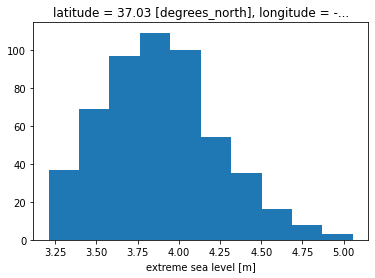

<IPython.core.display.Javascript object>

In [165]:
esl_check.isel(stations=0)["esl"].plot()

## Read ShorelineMonitor data from Zarr

A small sample (n=2000) of the ShorelineMonitor data (yearly averages) is saved as a zarr store. This notebook shows how to load the data from that zarr store with Python into, e.g., Xarray, and perform some simple operations. 

Next steps:
- process all shorelinemonitor data into the zarr storage
- include explicit chunking?
- move to cloud
- load data with rioxarray to include geospatial operations
- provide a few more examples of plots and data operations
- include stac catalogue
- add other shorelinemonitor feature, such as country, sandy_flag etc.?

Requirements:
- zarr
- xarray
- dask 

Optional:
- geopandas
- rioxarray

In [153]:
# ShorelineMonitor paths
sm_dir = coclico_data_dir.joinpath("16_shorelinemonitor")
sm_zstore_path = sm_dir.joinpath("shorelinemonitor.zarr")

sm = xr.open_zarr(sm_zstore_path)

<IPython.core.display.Javascript object>

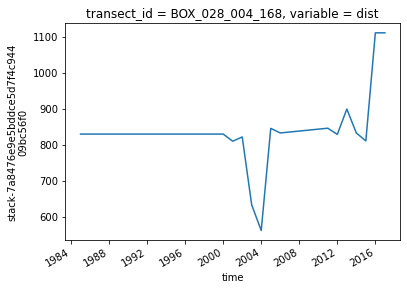

<IPython.core.display.Javascript object>

In [154]:
# Example: get first transect by index and plot
sm.isel(transect_id=0).to_array().plot()

### Additional info about zarr store's

Just some examples to show how the zarr store is now formatted 

In [155]:
# connect to zarr store with open and print general info
sm_zstore = zarr.open(sm_zstore_path)
sm_zstore.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"dist, lat, lon, time, transect_id"


<IPython.core.display.Javascript object>

In [156]:
# or print store tree
sm_zstore.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='dist (1996, 33) float…

<IPython.core.display.Javascript object>

In [157]:
# the zarr directory also contains "consolidated metadata"
os.listdir(sm_zstore_path)

['.zattrs',
 '.zgroup',
 '.zmetadata',
 'dist',
 'lat',
 'lon',
 'time',
 'transect_id']

<IPython.core.display.Javascript object>

### Inspect certain zarr array  

Here, note that the chunk shape (998, 33) was detected automatically by zarr. In future, to get optimal io speed, we should think about the use case and set the chunk dimension according to that use case. For example, for the showing the time-series per transect the store should be chunked across the transect_id dimension, but not over the years. 

In [158]:
sm_zstore["dist"].info

Name,/dist
Type,zarr.core.Array
Data type,float64
Shape,"(1996, 33)"
Chunk shape,"(998, 33)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,526944 (514.6K)
No. bytes stored,430613 (420.5K)


<IPython.core.display.Javascript object>

### Important notes on Zarr from Xarray perspective

Please note: 

1. Zarr can only read/write Zarr groups, but no individual zarr arrays.
2. Zarr arrays do not have dimensions names like NetCDF. Therefore, each Zarr array requires a special array attribute `_ARRAY_DIMENSIONS`. Without this attribute, data cannot be load from zarr into xarray. 

For an extensive discussion see [this entry of the xarray documentation](https://xarray.pydata.org/en/stable/internals/zarr-encoding-spec.html)

The attributes from a certain array can be listed like:

In [159]:
dict(sm_zstore["dist"].attrs)

{'_ARRAY_DIMENSIONS': ['transect_id', 'time'], 'coordinates': 'lon lat'}

<IPython.core.display.Javascript object>